# Rental List Classification

In [50]:
import pandas as pd
from matplotlib import pyplot as plt
from ggplot import *
import seaborn as sns
%matplotlib inline

In [2]:
# read in the training data set
train_set = pd.read_json(r'..\data\train.json')
test_set = pd.read_json(r'..\data\test.json')
print("Read in training data set with size of {} * {}".format(train_set.shape[0], train_set.shape[1]))
print("Read in testing data set with size of {} * {}".format(test_set.shape[0], test_set.shape[1]))

Read in training data set with size of 49352 * 15
Read in testing data set with size of 74659 * 14


In [3]:
# seperate the features and the response
train_X = train_set.drop('interest_level', axis=1)
train_y = train_set['interest_level']


In [4]:
test_set.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address'],
      dtype='object')

In [5]:
train_set.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


## Data explorary analysis

count    49352.000000
mean         1.262346
std          0.874721
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
dtype: float64


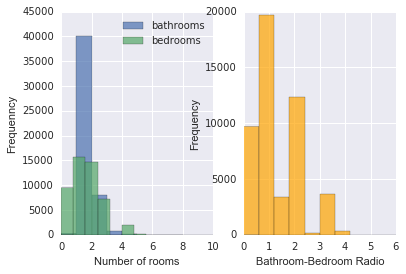

In [80]:
# Number of bedrooms, bathrooms
# create a new var: bathroom-bedroom ratio
# for those do not have a bedroom, assume they are studio and set the number of bedrooms to 1
bb_ratio = train_set['bedrooms'] / train_set['bathrooms'].apply(lambda x: x if x != 0 else 1)
print(bb_ratio.describe())


for room in ('bathrooms', 'bedrooms'):
    ax = plt.subplot(1, 2, 1)
    train_set[room].hist(alpha=0.7, label=room)
ax.set(xlabel='Number of rooms', ylabel='Frequenncy')
ax.legend(loc=1)

ax = plt.subplot(1, 2, 2)
ax.hist(bb_ratio, color='orange', alpha=0.7)
ax.set(xlabel='Bathroom-Bedroom Radio', ylabel='Frequency')
plt.show()
